In [1]:
from __future__ import print_function
from datetime import datetime
import logging
import multiprocessing
import os
import sys
import tarfile
import time

import numpy as np
from matplotlib import pyplot as plt
from mxboard import SummaryWriter
import mxnet as mx
from mxnet import gluon, test_utils
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd

/home/guangyi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


set training parameters and latent vector

In [2]:
batch_size   = 64
z_dim        = 100
n_continuous = 2  # continuous factor
n_categories = 10  # categorical factor
ctx = mx.gpu(0) 
# ctx = mx.cpu()
#if mx.test_utils.list_gpus() else mx.cpu()

Download an preprocess the MNIST dataset

In [3]:
# Pixel values of mnist image are normalized to be from 0 to 1.
mnist_data = test_utils.get_mnist()
train_data = mnist_data['train_data']*2-1
train_label = nd.one_hot(nd.array(mnist_data['train_label']), 10)
train_iter = mx.io.NDArrayIter(data=train_data, label=train_label, batch_size=batch_size)

In [4]:
train_data.shape

(60000, 1, 28, 28)

In [5]:
train_data = nd.array(train_data)

In [6]:
type(train_data)

mxnet.ndarray.ndarray.NDArray

In [7]:
train_dataloader = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, last_batch='rollover', num_workers=multiprocessing.cpu_count()-1)

Generator

In [8]:
class Generator(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Generator, self).__init__(**kwargs)
        with self.name_scope():
            #input size: batch_size x 112
            self.prev = nn.HybridSequential()
            self.prev.add(nn.Dense(1024, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
            self.prev.add(nn.Dense(128*7*7, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
            self.G = nn.HybridSequential()
         
        
#             self.G.add(nn.Conv2DTranspose(64 * 8, 4, 1, 0, use_bias=False)) #outputsize: (64*8)x4x4
# #             self.G.add(nn.Conv2DTranspose(64 * 8, 4, 1, 1, use_bias=False))
#             self.G.add(nn.BatchNorm())
#             self.G.add(nn.Activation('relu'))
# #             self.G.add(nn.Conv2DTranspose(64 * 4, 4, 2, 1, use_bias=False))
#             self.G.add(nn.Conv2DTranspose(64 * 4, 3, 2, 1, use_bias=False)) #output size: (64*4)x7x7
#             self.G.add(nn.BatchNorm())
#             self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(64, 4, 2, 1, use_bias=False)) #output size: 64x14x14 
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(1, 4, 2, 1, use_bias=False)) #output size: 1x28x28
#             self.G.add(nn.BatchNorm())
#             self.G.add(nn.Activation('relu'))
# #             self.G.add(nn.Conv2DTranspose(3, 4, 2, 3, use_bias=False))
# #             self.G.add(nn.Conv2DTranspose(3, 1, 1, 0, use_bias=False)) #output size: 3x28x28
#             self.G.add(nn.Conv2DTranspose(1, 1, 1, 0, use_bias=False)) #output size: 1x28x28
            self.G.add(nn.Activation('tanh'))

    def hybrid_forward(self, F, x):
        x = self.prev(x)
        x = F.reshape(x, (0, -1, 7, 7)) #reshape x from batch_sizex(128*7*7)x1x1 to batch_sizex128x7x7
        return self.G(x)

In [9]:
class Discriminator(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        with self.name_scope():
            # input size: 1x28x28
            self.D = nn.HybridSequential()
            self.D.add(nn.Conv2D(64, 4, 2, 1, use_bias=False)) #output size: 64x14x14
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(64 * 2, 4, 2, 1, use_bias=False)) #output size: (64*2)x7x7
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
#             self.D.add(nn.Conv2D(64 * 4, 4, 2, 1, use_bias=False)) #output size: (64*4)x4x4
#             self.D.add(nn.BatchNorm())
#             self.D.add(nn.LeakyReLU(0.2))
# #             self.D.add(nn.Conv2D(64 * 8, 4, 2, 1, use_bias=False))
#             self.D.add(nn.Conv2D(64 * 8, 3, 1, 0, use_bias=False)) #output size: (64*8)x1x1
# #             self.D.add(nn.Conv2D(64 * 8, 1, 1, 0, use_bias=False)) #(64*4)x4x4
#             self.D.add(nn.BatchNorm())
#             self.D.add(nn.LeakyReLU(0.2))

            self.D.add(nn.Dense(1024, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
       
            self.prob = nn.Dense(1)
            self.feat = nn.HybridSequential()
            self.feat.add(nn.Dense(128, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
            self.category_prob = nn.Dense(n_categories)
            self.continuous_mean = nn.Dense(n_continuous)
            self.Q = nn.HybridSequential()
            self.Q.add(self.feat, self.category_prob, self.continuous_mean)

    def hybrid_forward(self, F, x):
        x               = self.D(x)
        prob            = self.prob(x)
        feat            = self.feat(x)
        category_prob   = self.category_prob(feat)
        continuous_mean = self.continuous_mean(feat)
        
        return prob, category_prob, continuous_mean

In [10]:
generator = Generator()
generator.hybridize()
generator.initialize(mx.init.Normal(0.002), ctx=ctx)

discriminator = Discriminator()
discriminator.hybridize()
discriminator.initialize(mx.init.Normal(0.002), ctx=ctx)

lr   = 0.0001
beta = 0.5

g_trainer = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})
d_trainer = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})
q_trainer = gluon.Trainer(discriminator.Q.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})

Create vectors with real (=1) and fake labels (=0).

In [11]:
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

Load a pretrained model.

In [12]:
if os.path.isfile('infogan_d_latest.params') and os.path.isfile('infogan_g_latest.params'):
    discriminator.load_parameters('infogan_d_latest.params', ctx=ctx, allow_missing=True, ignore_extra=True)
    generator.load_parameters('infogan_g_latest.params', ctx=ctx, allow_missing=True, ignore_extra=True)

In [13]:
os.path.isfile('infogan_d_latest.params')

True

In [12]:
loss1 = gluon.loss.SigmoidBinaryCrossEntropyLoss()
loss2 = gluon.loss.L2Loss()
loss3 = gluon.loss.SoftmaxCrossEntropyLoss()

In [13]:
def create_generator_input():
    
    #create random noise
    z      = nd.random_normal(0, 1, shape=(batch_size, z_dim), ctx=ctx)
    label  = nd.array(np.random.randint(n_categories, size=batch_size)).as_in_context(ctx)
    c1     = nd.one_hot(label, depth=n_categories).as_in_context(ctx)
    c2     = nd.random.uniform(-1, 1, shape=(batch_size, n_continuous)).as_in_context(ctx)

    # concatenate random noise with c which will be the input of the generator
    return nd.concat(z, c1, c2, dim=1), label, c2

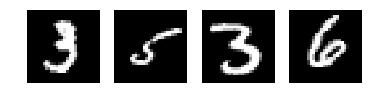

In [14]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().reshape(28, 28) + 1.0)* 127.5).astype(np.uint8), cmap='gray')
    plt.axis('off')
for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(nd.array(train_data[i + 10]))
plt.show()

Epoch 0


/home/guangyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/home/guangyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/home/guangyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide
INFO:mxboard.event_file_writer:successfully opened events file: ./logs//Loss_D/test/events.out.tfevents.1544017436.sribd-linux02
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:successfully opened events file: ./logs//Loss_G/test/events.out.tfevents.1544017436.sribd-linux02
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:successfully opened events file: ./logs/events.out.tfevents.1544017436.sribd-linux02
INFO:m

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

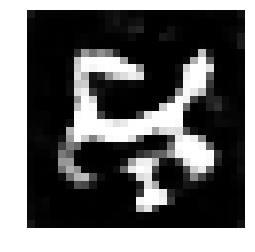

Epoch 1


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

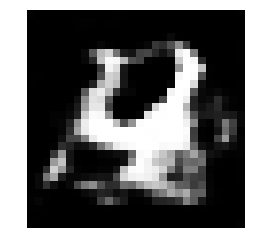

Epoch 2


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

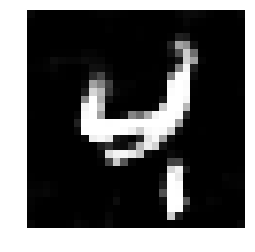

Epoch 3


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

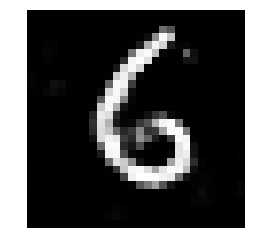

Epoch 4


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

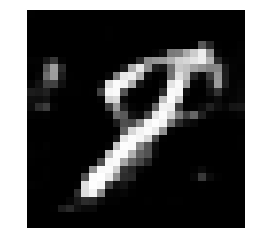

Epoch 5


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

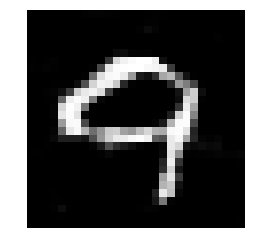

Epoch 6


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

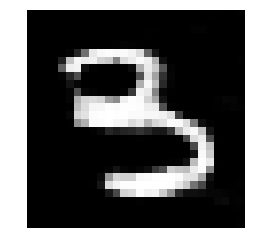

Epoch 7


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

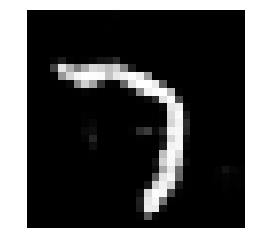

Epoch 8


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

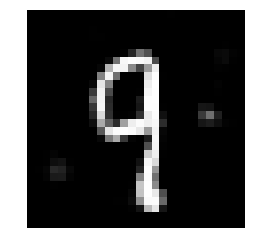

Epoch 9


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

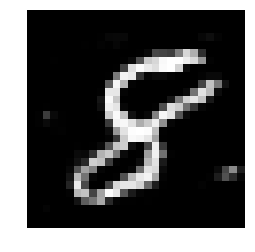

Epoch 10


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

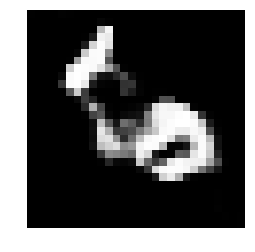

Epoch 11


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

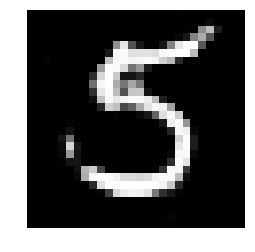

Epoch 12


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

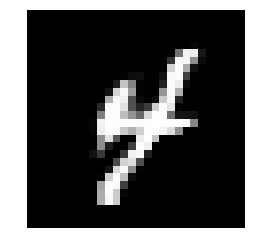

Epoch 13


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

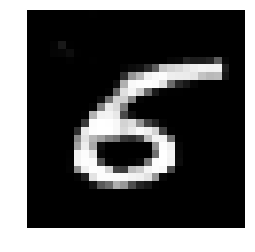

Epoch 14


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

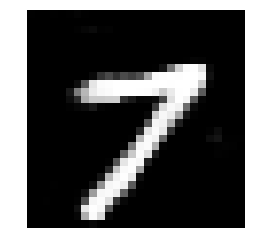

Epoch 15


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

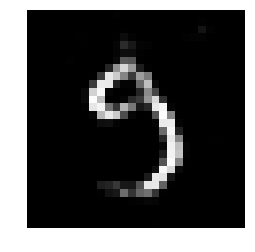

Epoch 16


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

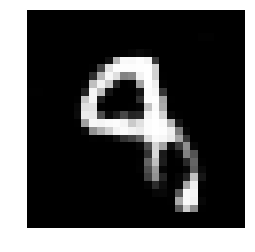

Epoch 17


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

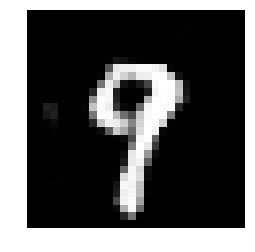

Epoch 18


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

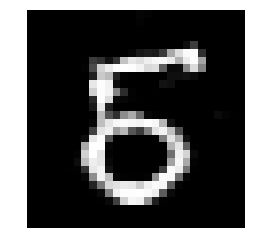

Epoch 19


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

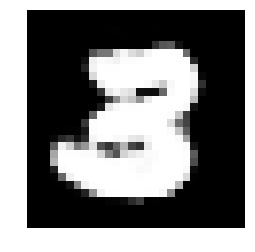

Epoch 20


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

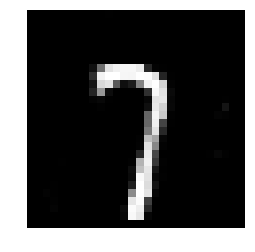

Epoch 21


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

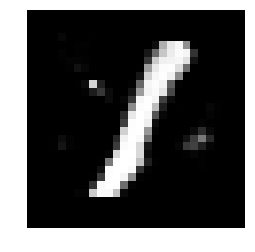

Epoch 22


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

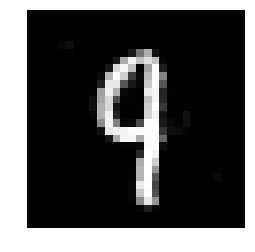

Epoch 23


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

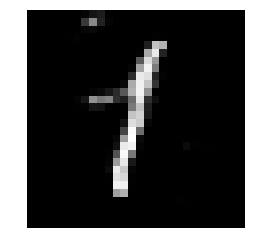

Epoch 24


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

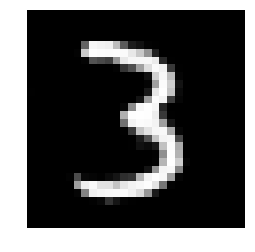

Epoch 25


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

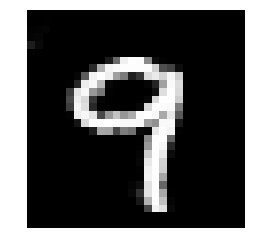

Epoch 26


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

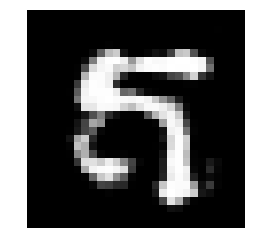

Epoch 27


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

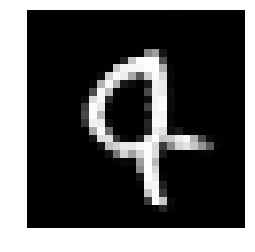

Epoch 28


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

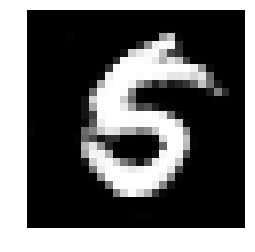

Epoch 29


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

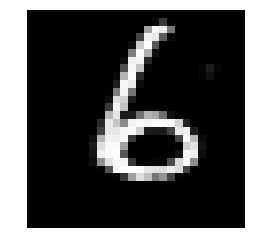

Epoch 30


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

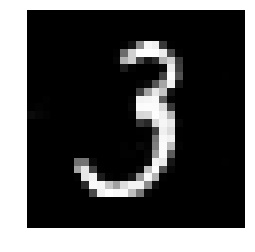

Epoch 31


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

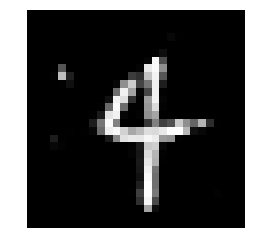

Epoch 32


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

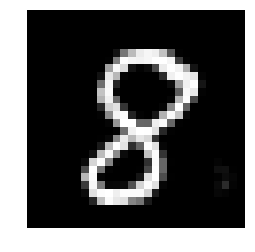

Epoch 33


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

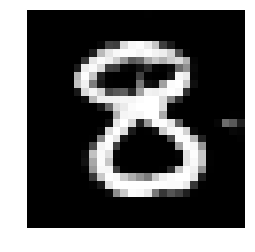

Epoch 34


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

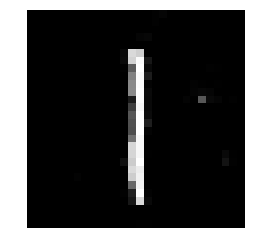

Epoch 35


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

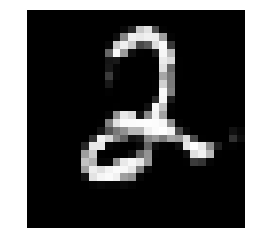

Epoch 36


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

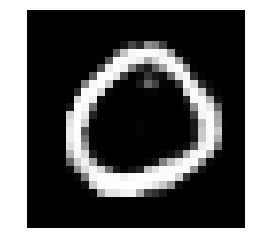

Epoch 37


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

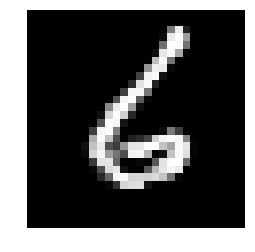

Epoch 38


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

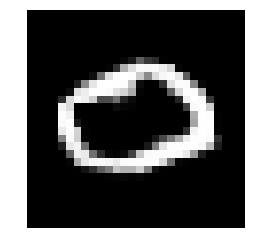

Epoch 39


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

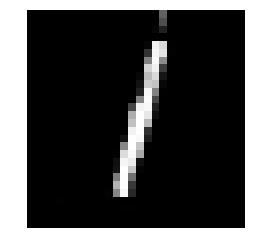

Epoch 40


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

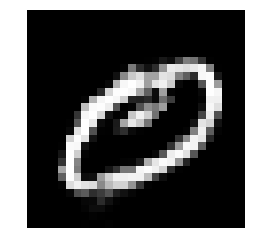

Epoch 41


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

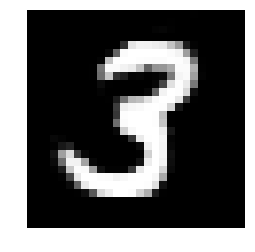

Epoch 42


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

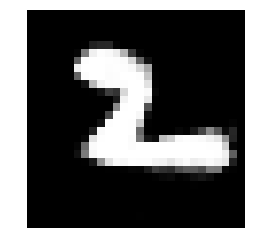

Epoch 43


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

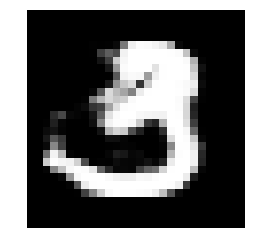

Epoch 44


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

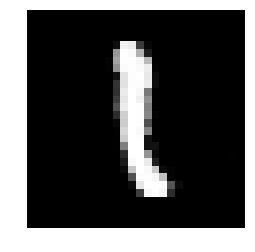

Epoch 45


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

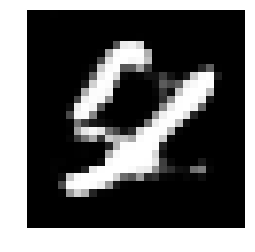

Epoch 46


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

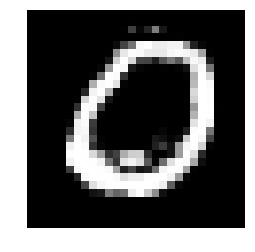

Epoch 47


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

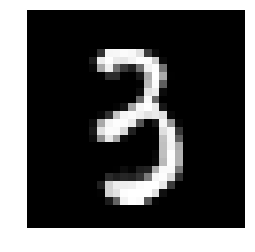

Epoch 48


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

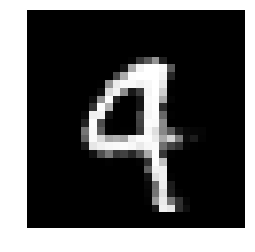

Epoch 49


INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event t

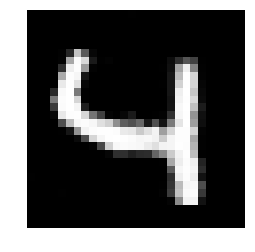

In [15]:
with SummaryWriter(logdir='./logs/') as sw:
    
    epochs = 50
    counter = 0
    for epoch in range(epochs):
        print("Epoch", epoch)
        starttime = time.time()
        
        d_error_epoch = nd.zeros((1,), ctx=ctx)
        g_error_epoch = nd.zeros((1,), ctx=ctx)
        
        for idx, data in enumerate(train_dataloader):
            counter = counter + 1    
            #get real data and generator input
            real_data = data.as_in_context(ctx)     
            g_input, label, c2 = create_generator_input()

            
            #Update discriminator: Input real data and fake data
            with autograd.record():
                output_real,_,_ = discriminator(real_data)
                d_error_real    = loss1(output_real, real_label)
                
                # create fake image and input it to discriminator
                fake_image      = generator(g_input)
                output_fake,_,_ = discriminator(fake_image.detach())
                d_error_fake    = loss1(output_fake, fake_label)
                
                # total discriminator error
                d_error         = d_error_real + d_error_fake

            d_error_epoch += d_error.mean()
            
            #Update D every second iteration
            if (counter+1) % 2 == 0:
                d_error.backward()
                d_trainer.step(batch_size)

            #Update generator: Input random noise and latent code vector
            with autograd.record():
                fake_image = generator(g_input)
                output_fake, category_prob, continuous_mean = discriminator(fake_image)
                g_error = loss1(output_fake, real_label) + loss3(category_prob, label) + loss2(c2, continuous_mean)

            g_error.backward()
            g_error_epoch += g_error.mean()
            
            g_trainer.step(batch_size)
            q_trainer.step(batch_size)

            # logging
            if idx % 10 == 0:
           
                logging.info('speed: {} samples/s'.format(batch_size / (time.time() - starttime)))
                logging.info('discriminator loss = %f, generator loss = %f at iter %d epoch %d'
                         %(d_error_epoch.asscalar()/idx,g_error_epoch.asscalar()/idx, idx, epoch))

                g_input,_,_ = create_generator_input()
                
                # create some fake image for logging in MXBoard
                fake_image = generator(g_input)
                

                sw.add_scalar(tag='Loss_D', value={'test':d_error_epoch.asscalar()/idx}, global_step=counter)
                sw.add_scalar(tag='Loss_G', value={'test':d_error_epoch.asscalar()/idx}, global_step=counter)
                sw.add_image(tag='data_image', image=((fake_image[0]+ 1.0) * 127.5).astype(np.uint8)  , global_step=counter)
                sw.flush()
        visualize(fake_image[0])
        plt.show()
        discriminator.save_parameters("infogan_d_latest.params")
        generator.save_parameters("infogan_g_latest.params")

The influence of c1: different c1 means different digit

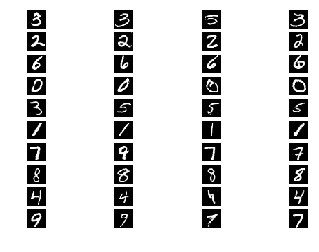

In [17]:
num_image = 4
for digit in range(10):
    for i in range(num_image):
        z = mx.nd.random_normal(0, 1, shape=(1, z_dim), ctx=ctx)        
        c1 = nd.one_hot(nd.array([digit]), 10).as_in_context(ctx)
        c2 = nd.random.uniform(-1, 1, shape=(1, n_continuous)).as_in_context(ctx)
        zz = nd.concat(z,c1,c2,dim=1)
        img = generator(zz)
        plt.subplot(10,num_image,digit*num_image+i+1)
        visualize(img[0])
plt.show()

The influence of c2: different c2 means different rotation angle

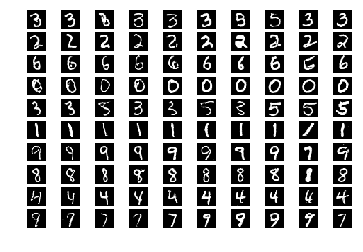

In [20]:
num_image = 10
for digit in range(10):
    for i in range(num_image):
        z = mx.nd.random_normal(0, 1, shape=(1, z_dim), ctx=ctx)        
        c1 = nd.one_hot(nd.array([digit]), 10).as_in_context(ctx)
        c2 = nd.tile(nd.array([-1+i/10]),(1,n_continuous)).as_in_context(ctx)
#         c2 = nd.random.uniform(-1, 1, shape=(1, n_continuous)).as_in_context(ctx)
        zz = nd.concat(z,c1,c2,dim=1)
        img = generator(zz)
        plt.subplot(10,num_image,digit*num_image+i+1)
        visualize(img[0])
plt.show()

In [22]:
discriminator = Discriminator()
discriminator.load_parameters("infogan_d_latest.params", ctx=ctx, ignore_extra=True)

discriminator1 = discriminator

discriminator = nn.HybridSequential()
for i in range(8):
    discriminator.add(discriminator1.D[i])
print (discriminator)

discriminator.hybridize()

HybridSequential(
  (0): Conv2D(1 -> 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(0.2)
  (2): Conv2D(64 -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=128)
  (4): LeakyReLU(0.2)
  (5): Dense(6272 -> 1024, linear)
  (6): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=1024)
  (7): Activation(relu)
)


In [24]:
generator = Generator()
generator.load_parameters("infogan_g_latest.params", ctx=ctx, ignore_extra=True)

generator1 = generator

generator = nn.HybridSequential()
for i in range(5):
    generator.add(generator1.G[i])
print (generator)

generator.hybridize()

HybridSequential(
  (0): Conv2DTranspose(64 -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
  (2): Activation(relu)
  (3): Conv2DTranspose(1 -> 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): Activation(tanh)
)
